# Introduction
For your third capstone, you’ll complete an unsupervised learning project. You can choose your own research question or choose from one below.

How do you achieve the following using clustering techniques?

    Your chief marketing officer wants to know how much website traffic is due to spam and bots versus actual customers. How can you group the traffic?

Next steps:

Go out and find a dataset of interest. It could be one that helps you work on one of our recommended research questions, or any other dataset that addresses an unsupervised learning question of your own.

Explore the data. Get to know the data. Spend a lot of time going over its quirks and peccadilloes. You should understand how it was gathered, what's in it, and what the variables look like.

You should try several different approaches and really work to tune a variety of models before choosing what you consider to be the best performer.

Things to keep in mind: how do clustering and modeling compare? What are the advantages of each? Why would you want to use one over the other?

This will ultimately include the following deliverables:

    A Jupyter notebook that tells a compelling story about your data (to be submitted at the end of this checkpoint).
    A 15 to 30 minute presentation of your findings. You'll need to produce a deck and present it to the Thinkful community.
    Conduct the analysis in Jupyter. Provide a complete research report using the framework introduced in the previous module. The report should include compelling visualizations and actionable insights, telling the story to your intended audience. Walk through the analysis using clean, reproducible code. Include plenty of notes and comments to guide others through your thinking.

    Rather than create a deck in a presentation tool like PowerPoint or Google Slides, we will use Jupyter’s built-in slide deck capabilities. This cuts down on the time-consuming and error-prone process of copying-and-pasting into an external program. The presentation is also fully reproducible.

    On the day of your presentation, an evaluator from the Thinkful educator team will introduce you, and then you'll give your presentation. Afterward, the evaluator will ask you follow up questions and will grade your performance on your presentation. Members of the audience will also be encouraged to ask follow up questions.

Be prepared to talk about:

1. Your end-user and the value your project provides to them.
2. Quantifiable results based on the research you’ve conducted.
3. The visuals you chose and what they represent for your research.
4. Next steps you'd take to expand on your work.
5. A specified research question your model addresses.
6. How you chose your model specification and what alternatives you compared it to.
7. The practical uses of your model for an audience of interest.
8. Any weak points or shortcomings of your model.

# Cleaning and Importing Data
The dataset was obtained from Kaggle.com(Data). It is consists of website traffic data of 12,330 visits over the course of a year. The dataset comprised of 10 numerical and 8 categorical values. The main types of webpages are administrative, informational, and product related. The user duration for each of these webpages were tracked in the duration columns. 'Bounce Rates', 'Exit Rates' and 'Page Value' were calculated by google analytics for each page and visits. 

The bounce rate is the rate that a users enters a webpage and leaves the website from that page without ever going to any further webpages. The exit rate is the rate that the user leave the website from that page; this includes single page visits to visits from multiple pages(Bounce vs Exit Rates). Page value is calculated as rate that a page contributes to revenue.

The remaining variables pertain to the demographics of the users and timeframe: Special day, month, OS, browser, region, etc. These variables will be explored below to find correlations with Revenue. Furthermore the data will be inspected for outliers and cleaned below. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.preprocessing import normalize
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from keras import Sequential
from keras.layers import Dense
import warnings

%matplotlib inline
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Import data and print first five values
df = pd.read_csv('online_shoppers_intention.csv')
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0.0,0.0,0.0,0.0,1.0,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0.0,0.0,0.0,0.0,2.0,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0.0,-1.0,0.0,-1.0,1.0,-1.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0.0,0.0,0.0,0.0,2.0,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0.0,0.0,0.0,0.0,10.0,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
# Quick check of data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
Administrative             12316 non-null float64
Administrative_Duration    12316 non-null float64
Informational              12316 non-null float64
Informational_Duration     12316 non-null float64
ProductRelated             12316 non-null float64
ProductRelated_Duration    12316 non-null float64
BounceRates                12316 non-null float64
ExitRates                  12316 non-null float64
PageValues                 12330 non-null float64
SpecialDay                 12330 non-null float64
Month                      12330 non-null object
OperatingSystems           12330 non-null int64
Browser                    12330 non-null int64
Region                     12330 non-null int64
TrafficType                12330 non-null int64
VisitorType                12330 non-null object
Weekend                    12330 non-null bool
Revenue                    12330 non-null bool
dtypes:

In [4]:
# Check to see missing values
df.isna().sum()

Administrative             14
Administrative_Duration    14
Informational              14
Informational_Duration     14
ProductRelated             14
ProductRelated_Duration    14
BounceRates                14
ExitRates                  14
PageValues                  0
SpecialDay                  0
Month                       0
OperatingSystems            0
Browser                     0
Region                      0
TrafficType                 0
VisitorType                 0
Weekend                     0
Revenue                     0
dtype: int64

### Missing Values
The missing values identified above will be replaced with the median in each column as the mean is skewed by outliers. 

In [5]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12316.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.317798,80.906176,0.503979,34.506387,31.763884,1196.037057,0.022152,0.043003,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.322754,176.860432,1.270701,140.825479,44.490339,1914.372511,0.048427,0.048527,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,185.000000,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,8.000000,0.000000,0.000000,18.000000,599.766190,0.003119,0.025124,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.500000,0.000000,0.000000,38.000000,1466.479902,0.016684,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [6]:
df = df.fillna(df.median())
df.isna().sum()

Administrative             0
Administrative_Duration    0
Informational              0
Informational_Duration     0
ProductRelated             0
ProductRelated_Duration    0
BounceRates                0
ExitRates                  0
PageValues                 0
SpecialDay                 0
Month                      0
OperatingSystems           0
Browser                    0
Region                     0
TrafficType                0
VisitorType                0
Weekend                    0
Revenue                    0
dtype: int64

In [7]:
# Convert boolean column to 0 for false, 1 for true
bools = df[df.columns[-2:]]

for x in bools:
    df[x] = df[x].astype(int)

In [8]:
# Create dataset with only float columns
num_values = df.select_dtypes(include='float64')

# Replace rows with duration less than 0 with median
for num in num_values:
    i = 0
    for i, x in enumerate(df[num]):
        if x < 0:
            df.loc[i, num] = np.median(df[num])
            i += 1

### Identifying Outliers
After reviewing the dataset, only 3 variables were continuous: Admin Duration, Info Duration, Product Duration. The function below returns a count of the outliers in each variable withing the threshold. The treshold used is three standard deviations. Three standard deviations account for 99.7% of the variance of the data. Any datapoints outside of three standard deviations will be removed or transformed. 

In [9]:
def num_outliers(data, threshold):
    """ Count of all outliers of data
    Parameters 
    data(DataFrame): values used for z-score calc
    threshold(float): number of std deviations
    
    Returns outlier count for each column"""
    
    print('Number of Outliers per Column')
    # Calculate the zcore for each column and count outliers
    for num in data:
        z = np.abs(stats.zscore(df[num]))
        outliers = np.where(z>threshold)
        count = np.count_nonzero(outliers)
        print('{}: {}'.format(num, count))
    return

In [10]:
# Print count of values outside of 3 std deviations
threshold = 3
transform = ['Administrative_Duration', 'Informational_Duration',
             'ProductRelated_Duration']

num_outliers(transform, threshold)

Number of Outliers per Column
Administrative_Duration: 232
Informational_Duration: 230
ProductRelated_Duration: 219


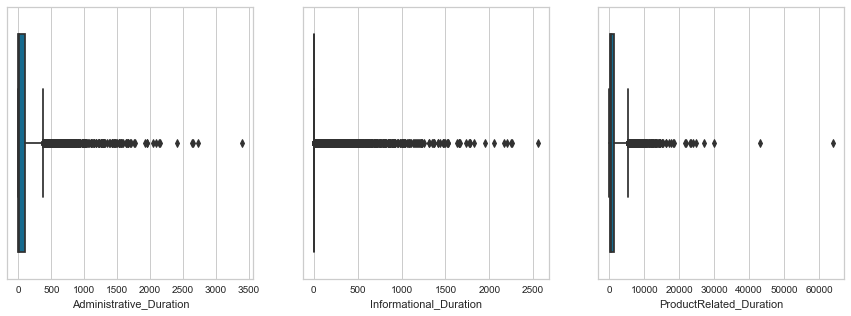

In [11]:
# Plot boxplots of num_values
plt.figure(figsize=(15, 5))
i = 0

for i, num in enumerate(transform):
    i += 1
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[num], whis=3)
    
plt.show()

#### Chart Analysis
The three charts above show two key points. First, the distribution of the data is positively skewed. Second, there are several points that are true outliers and should be removed. One example is the rightmost point in 'Product Related Duration'. This point is telling us that someone spent over 60k seconds looking at a single product. 60k seconds equates to about 17 hours, which points to this point being highly unlikely. Most likely the user left the webpage open in the background of his or her computer. 

### Dealing with Outliers
The first step of our data cleanup will be to remove all data points above three standard deviations. These data points represent less than five percent of the population. This will not significantly affect the results of the model. After the outliers are removed, the remaining data will be long transformed. This will eliminate the positive skew of the data.

In [12]:
# Remove ouliers from dataframe
for col in df[transform]:
    z = np.abs(stats.zscore(df[col]))
    row = []
    for i, x in enumerate(z):
        if x >= 3:
            row.append(i)        
    df.drop(row, axis=0, inplace=True)
    df.reset_index(drop=True, inplace=True)

# Log transform the data
for x in transform:
    df[x] = np.log1p(df[x])

# Print number of outliers
num_outliers(transform, threshold)

Number of Outliers per Column
Administrative_Duration: 0
Informational_Duration: 280
ProductRelated_Duration: 0


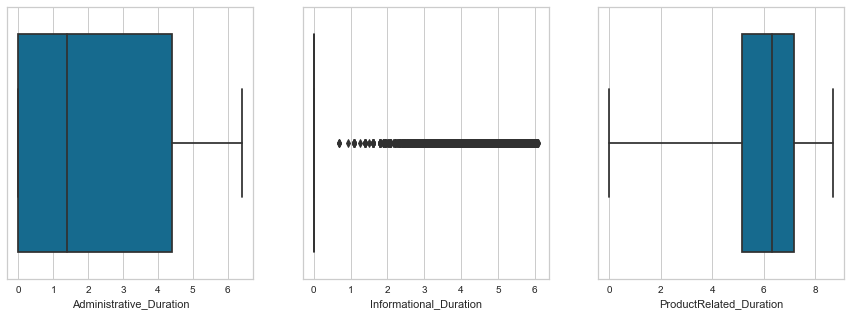

In [13]:
# Plot boxplots of num_values
plt.figure(figsize=(15, 5))
i = 0

for i, num in enumerate(transform):
    i += 1
    plt.subplot(1, 3, i)
    sns.boxplot(x=df[num], whis=3)
    
plt.show()

### Violin Plot Analysis


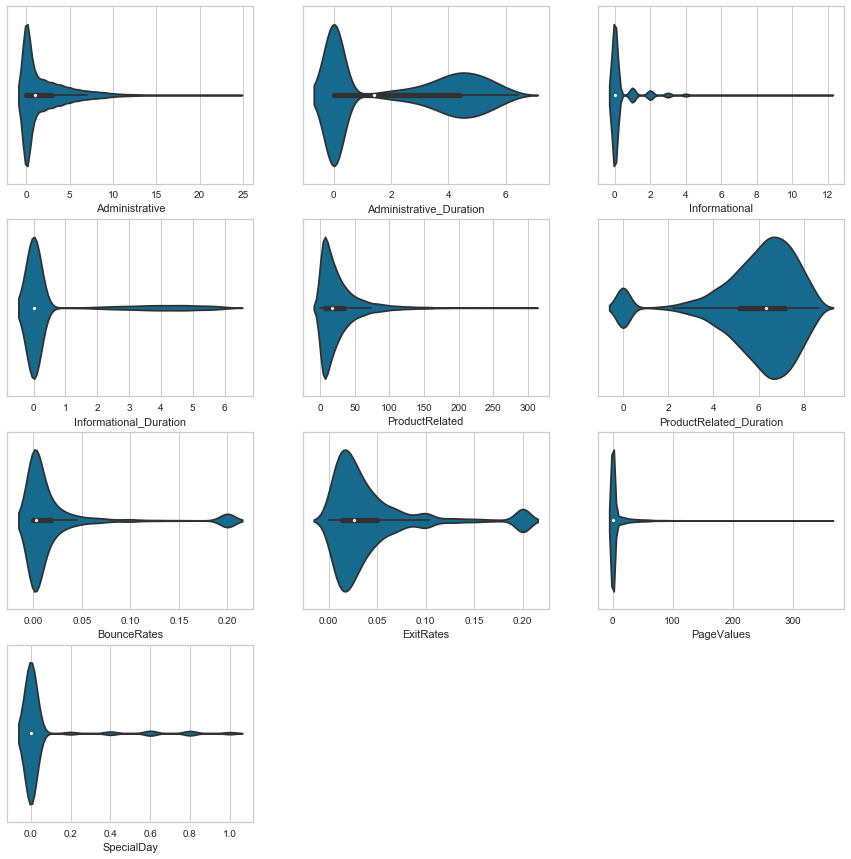

In [14]:
# Plot violin points of num_values
plt.figure(figsize=(15, 15))
i = 0

for i, num in enumerate(num_values):
    i += 1
    plt.subplot(4, 3, i)
    sns.violinplot(x=df[num])
    
plt.show()

# Data Exploration
The main variable that will be explored is Revenue, and the correlation of the other variables with it. The following questions will be answered in the data exploration:
    1. What are the number of sales?

In [15]:
def countbar_total(graph, x):
    """Add count to each bar in countplot
    
    Parameters
    graph: input the chart
    x(variable): x variable for chart"""
    for i, p in enumerate(graph.patches):
        height = p.get_height()
        graph.text(p.get_x()+p.get_width()/2., height*1.01,
            x.value_counts()[i], ha="center")

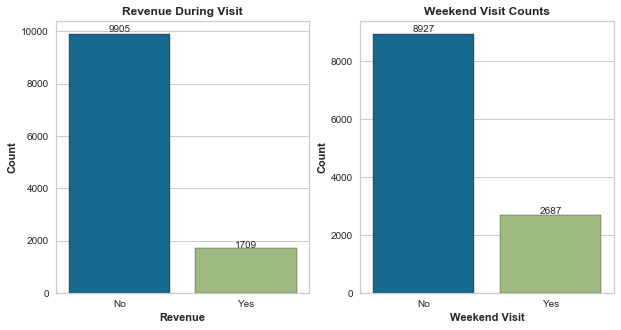

In [16]:
# Plot countplots of revenue and weekend
plt.figure(figsize=(10, 5))

plt.subplot(121)
graph = sns.countplot(x=df['Revenue'], edgecolor='black')

# Add countbar total for each bar
countbar_total(graph, df['Revenue'])

plt.title('Revenue During Visit', fontweight='bold')
plt.xlabel('Revenue', fontweight='bold')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Count', fontweight='bold')

plt.subplot(122)
graph = sns.countplot(x=df['Weekend'], edgecolor='black')

# Add countbar total for each bar
countbar_total(graph, df['Weekend'])

plt.title('Weekend Visit Counts', fontweight='bold')
plt.xlabel('Weekend Visit', fontweight='bold')
plt.xticks([0, 1], ['No', 'Yes'])
plt.ylabel('Count', fontweight='bold')

plt.show()

In [17]:
sales = df['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('Sale during visit:\n', sales)
print('\nPercentage of visits that convert to sales: {}%'.format(convert*100))

weekend = df['Weekend'].value_counts()
visits = weekend.sum()
convert = round(weekend[1]/visits, 4)

print('\nWeekend visits:\n', weekend)
print('\nPercentage of visits that are on weekend: {}%'.format(convert*100))
print('Percentage of weekend dates per week: {}%'.format(round((2/7*100),2)))

Sale during visit:
 0    9905
1    1709
Name: Revenue, dtype: int64

Percentage of visits that convert to sales: 14.71%

Weekend visits:
 0    8927
1    2687
Name: Weekend, dtype: int64

Percentage of visits that are on weekend: 23.14%
Percentage of weekend dates per week: 28.57%


In [18]:
# Create list of feature column names
col = list(df.columns)
col.remove('Revenue')

# List of all continuous variables
continuous = col[1:9]
continuous.remove('Informational')

# List of all categorical
categorical = col
for x in continuous:
    categorical.remove(x)

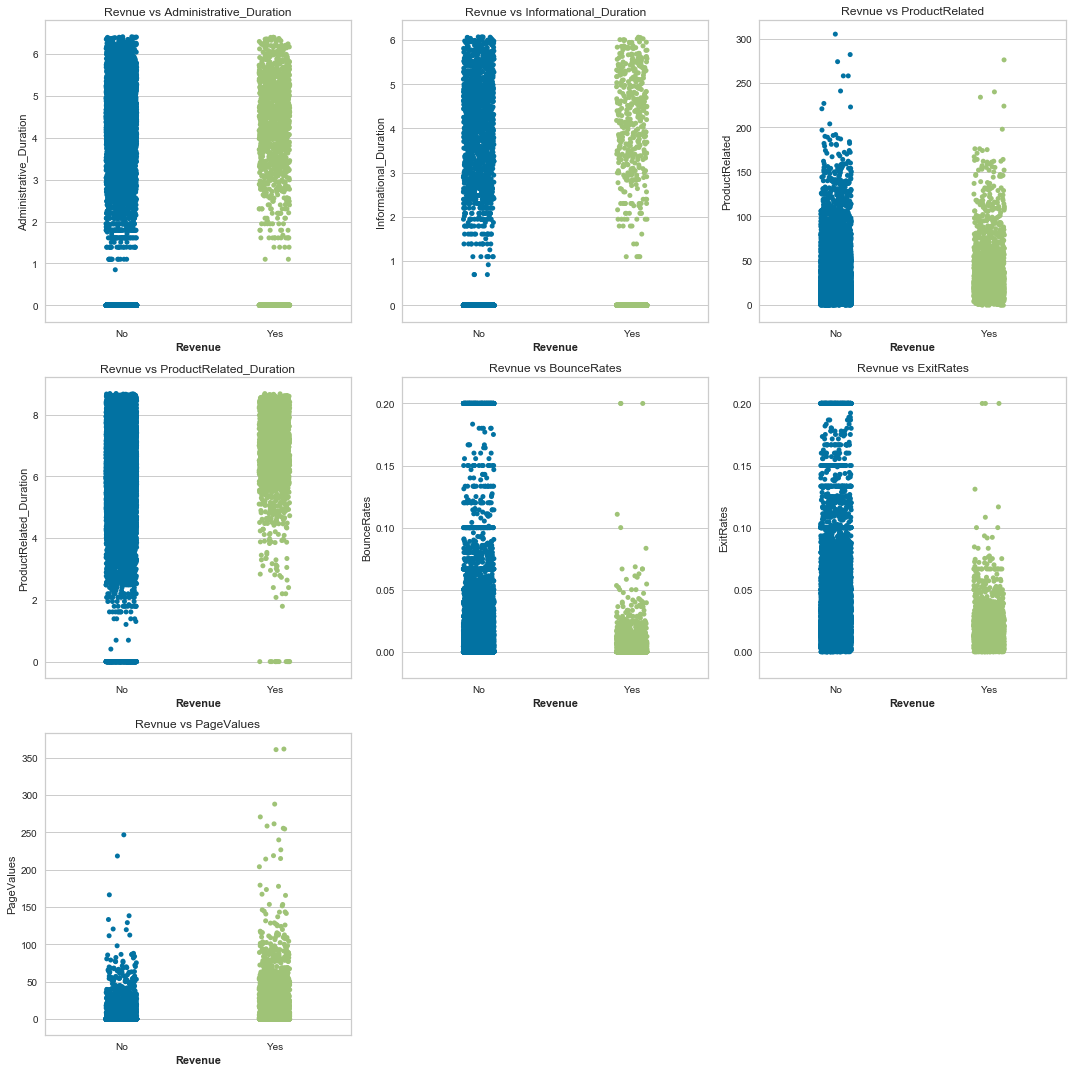

In [19]:
plt.figure(figsize=(15, 15))

df_rev0 = df[df['Revenue']==0] 
df_rev1 = df[df['Revenue']==1]


for i, x in enumerate(continuous):
    i += 1
    plt.subplot(3, 3, i)

    sns.stripplot(x=df['Revenue'], y=df[x])
    
    plt.title('Revnue vs {}'.format(x))
    plt.ylabel('{}'.format(x))
    plt.xlabel('Revenue', fontweight='bold')
    plt.xticks([0, 1], ['No', 'Yes'])
    
plt.tight_layout()    
plt.show()

In [20]:
month_counts = df['Month'].value_counts()
print(month_counts.sort_values(ascending=False))

May     3233
Nov     2700
Mar     1829
Dec     1649
Oct      521
Sep      418
Jul      407
Aug      404
June     271
Feb      182
Name: Month, dtype: int64


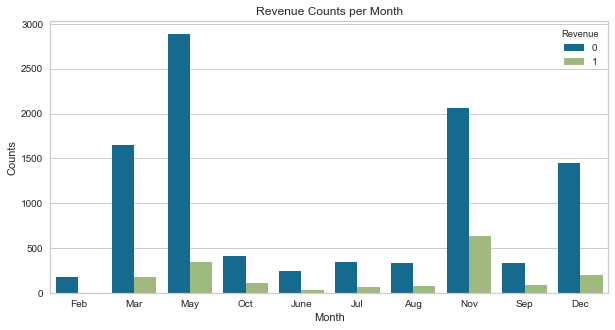

In [21]:
plt.figure(figsize=(10, 5))

sns.countplot(x=df['Month'], hue=df['Revenue'])
plt.title('Revenue Counts per Month')
plt.ylabel('Counts')
plt.xlabel('Month')
plt.show()

In [22]:
month = df[df['Month']=='Nov']

sales = month['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('Sale during November:\n', sales)
print('\nPercentage of visits in November that convert to sales: {}%'.format(convert*100))

Sale during November:
 0    2067
1     633
Name: Revenue, dtype: int64

Percentage of visits in November that convert to sales: 23.44%


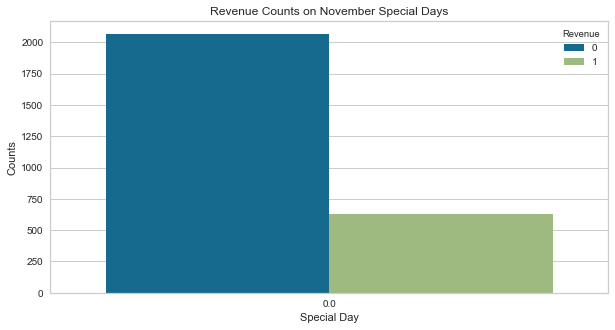

In [23]:
plt.figure(figsize=(10, 5))

sns.countplot(x=month['SpecialDay'], hue=month['Revenue'])
plt.title('Revenue Counts on November Special Days')
plt.ylabel('Counts')
plt.xlabel('Special Day')
plt.show()

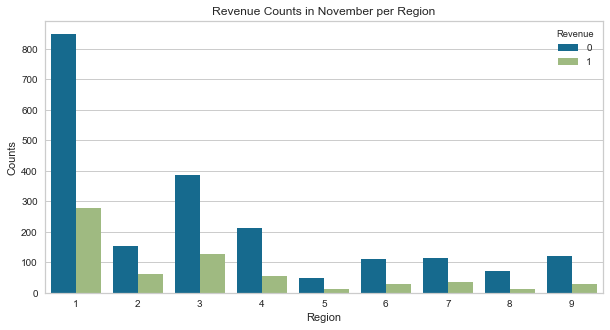

In [24]:
plt.figure(figsize=(10, 5))

sns.countplot(x=month['Region'], hue=month['Revenue'])
plt.title('Revenue Counts in November per Region')
plt.ylabel('Counts')
plt.xlabel('Region')
plt.show()

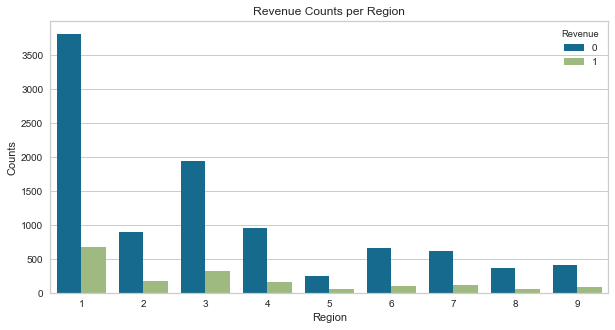

In [25]:
plt.figure(figsize=(10, 5))

sns.countplot(x=df['Region'], hue=df['Revenue'])
plt.title('Revenue Counts per Region')
plt.ylabel('Counts')
plt.xlabel('Region')
plt.show()

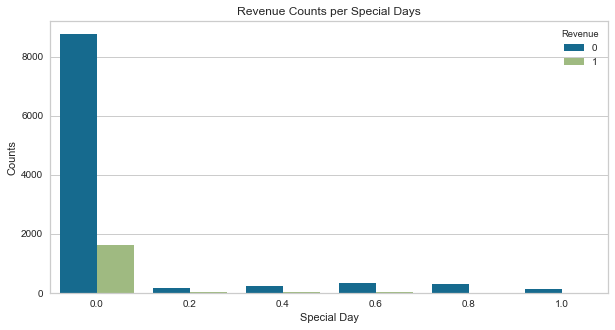

In [26]:
plt.figure(figsize=(10, 5))

sns.countplot(x=df['SpecialDay'], hue=df['Revenue'])
plt.title('Revenue Counts per Special Days')
plt.ylabel('Counts')
plt.xlabel('Special Day')
plt.show()

In [27]:
print(df['SpecialDay'].value_counts())

special = df[df['SpecialDay']>0]
not_special = df[df['SpecialDay']==0]

sales = special['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('\nSale during Special Days:\n', sales)
print('\nPercentage of visits during Special Days that convert to sales: {}%'.format(convert*100))

sales = not_special['Revenue'].value_counts()
visits = sales.sum()
convert = round(sales[1]/visits, 4)

print('\nSale during Normal Days:\n', sales)
print('\nPercentage of visits during Normal Days that convert to sales: {}%'.format(convert*100))

0.0    10401
0.6      343
0.8      314
0.4      235
0.2      172
1.0      149
Name: SpecialDay, dtype: int64

Sale during Special Days:
 0    1138
1      75
Name: Revenue, dtype: int64

Percentage of visits during Special Days that convert to sales: 6.18%

Sale during Normal Days:
 0    8767
1    1634
Name: Revenue, dtype: int64

Percentage of visits during Normal Days that convert to sales: 15.709999999999999%


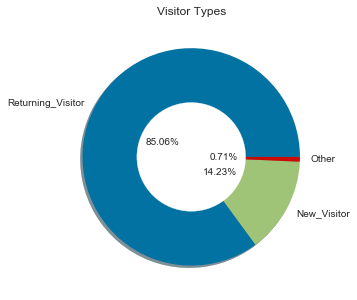

In [28]:
# Create a circle for the center of the plot
plt.figure(figsize=(10, 5))
my_circle=plt.Circle((0, 0), 0.5, color='white')
user = df['VisitorType'].value_counts()

plt.pie(user, labels=user.index, autopct='%1.2f%%', shadow=True, 
        pctdistance=.3, labeldistance=1.1)
p = plt.gcf()
p.gca().add_artist(my_circle)

plt.title('Visitor Types')
plt.show()

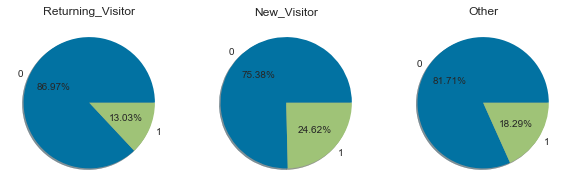

In [29]:
plt.figure(figsize=(10, 5))

visit = df['VisitorType'].unique()


for i, x in enumerate(visit):
    i += 1
    plt.subplot(1, 3, i)
    
    # Create dataframe for each user type
    user = df[df['VisitorType']==x]
    user = user['Revenue'].value_counts()

    plt.pie(user, labels=user.index, autopct='%1.2f%%', shadow=True, 
            pctdistance=.6, labeldistance=1.1)
    
    plt.title('{}'.format(x))

plt.show()

# Correlations
The correlations of each variable is plotted in the heatmap below. The highlights of the heatmap is listed below:
    1. Bounce Rates and Exit Rates are .91 correlated, which indicative that the bounce rate of a page is included in the calculation of the exit rate.
    2. Bounce Rates and Exit Rates have a strong negative correlation to the product duration. Meaning that the majority of users spend very little time on product pages before exiting the website. 
    3. Admin, Info, and Product pages were all highly correlated to their perspective duration variable. 
    4. Page value was the most correlated item to Revenue, which agrees to the conclusions from the chart above. 
    5. Exit rate is the most negative correlated variable to Revenue.
    
### Drop Variables
The strong correlation of bounce rates and exit rates indicate that these variables are near identical. Inclusion of both of these variables will create noise in the model. As such, Bounce Rates will be dropped as it less correlated to revenue. 

In [30]:
# Convert Visitor type to int
# Returning = 0, New = 1, Other = 2
objects = df.select_dtypes(include='object')

for obj in objects:
    temp = {i: j for j, i in enumerate(set(df[obj]))} 
    res = [temp[i] for i in df[obj]] 
    df[obj] = list(res)

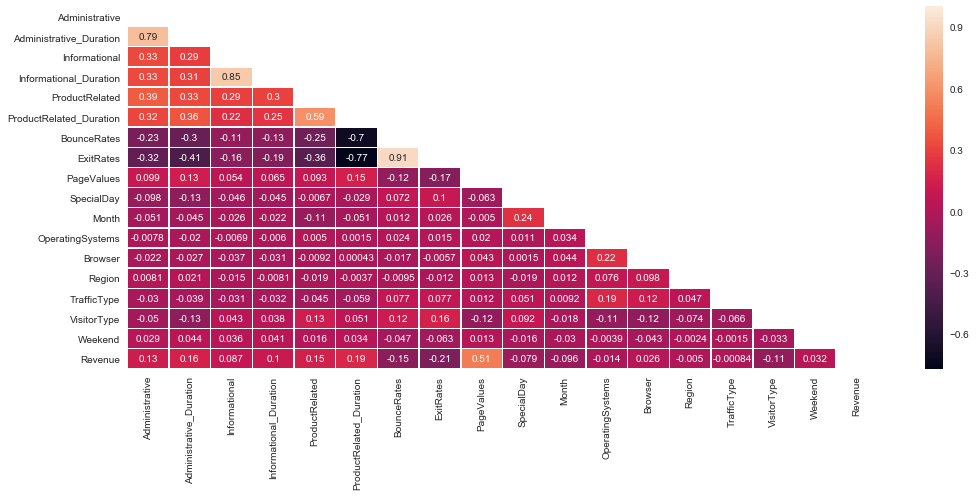

In [31]:
# plot correlation heatmap
df_cor = normalize(df)
df_corr = df.corr()

# Plot correlation heatmap
plt.figure(figsize=(15, 7))

# Clean up the heatmap and remove repeat values
mask = np.zeros_like(df_corr)
mask[np.triu_indices_from(mask)] = True

# PLot the heatmap of the correlations
sns.heatmap(df_corr, annot=True, linewidths=.5, mask=mask)
plt.tight_layout()
plt.show()

In [32]:
# Print the correlations of Revenue
print(df_corr['Revenue'].sort_values(ascending=False))

Revenue                    1.000000
PageValues                 0.509269
ProductRelated_Duration    0.188704
Administrative_Duration    0.157775
ProductRelated             0.151184
Administrative             0.126436
Informational_Duration     0.102055
Informational              0.086574
Weekend                    0.032050
Browser                    0.026332
TrafficType               -0.000844
Region                    -0.005023
OperatingSystems          -0.013689
SpecialDay                -0.078732
Month                     -0.096266
VisitorType               -0.107866
BounceRates               -0.149817
ExitRates                 -0.205427
Name: Revenue, dtype: float64


## Clustering
The most high correlated features to revenue, page value and exit rate, will be clustered together to find similar groups within the data set.

## K-Means
The first clustering method that will be used is the K-Means. WHY KMEANS. To find the ideal number of clusters an elbow chart was used. WHY ELBOW CHART. The elbow chart below shows that the ideal number of clusters in this dataset is 6. Unfortunately, the k-mean chart of page value and exit rate did not form any informative clusters. The mean shift method could provide better insight to the groups within the dataset. 

In [58]:
features = df.drop('Revenue', axis=1)
X = StandardScaler().fit_transform(features)

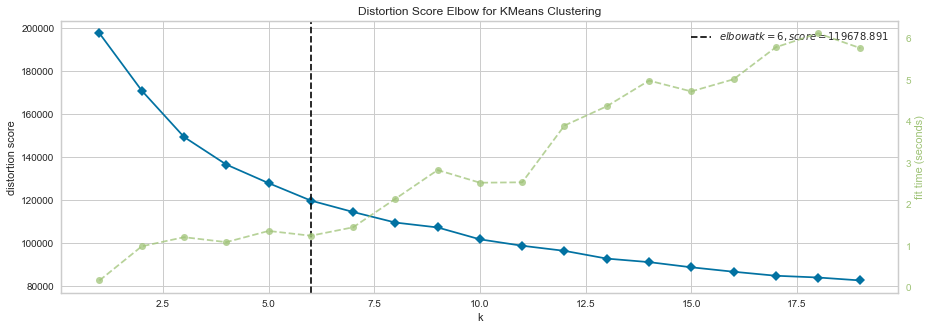

In [59]:
km = KMeans()

plt.figure(figsize=(15, 5))

# Find the optimal number of clusters for KMeans
vis = KElbowVisualizer(km, k=(1,20))
vis.fit(X)
vis.poof()
n = vis.elbow_value_

plt.show()

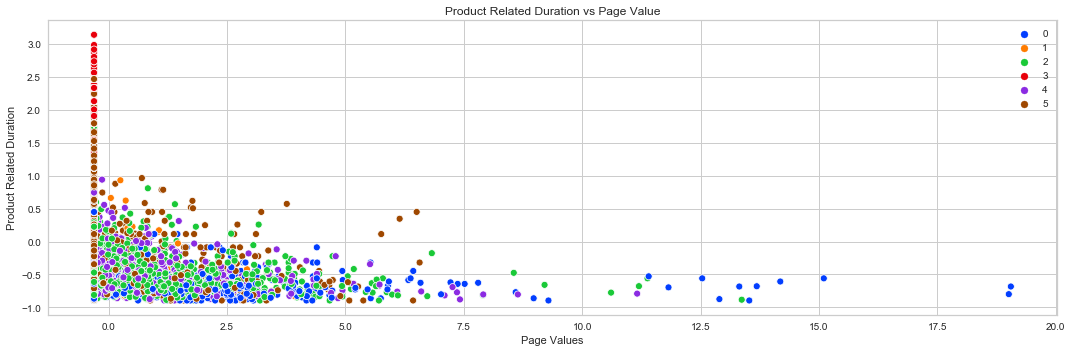

In [60]:
plt.figure(figsize=(15, 5))

model = KMeans(n_clusters=n).fit_predict(X)
pal = sns.color_palette('bright', n)
sns.scatterplot(x=X[:,8], y=X[:,7], hue=model, palette=pal)
plt.ylabel('Product Related Duration')
plt.xlabel('Page Values')
plt.title('Product Related Duration vs Page Value')

plt.tight_layout()
plt.show()

## Mean Shift
EXPLAIN MEAN SHIFT. The quantile select was .4 BECAUSE QUANTILE REASON. Five clusters were estimated and plotted. Unfortunately, the chart was not very informative as the majority of the data points were labeled group 0. 

In [63]:
# Set the bandwidth 
band = estimate_bandwidth(X, quantile=.4, n_samples=5000)

# Fit model
ms = MeanShift(bandwidth=band, bin_seeding=True)
ms.fit(X)

# Extract cluster assignments for each data point
labels = ms.labels_

# Coordinates of the cluster centers
centers = ms.cluster_centers_

# Count our clusters.
clusters = len(np.unique(labels))

print("Number of estimated clusters: {}".format(clusters))

Number of estimated clusters: 5


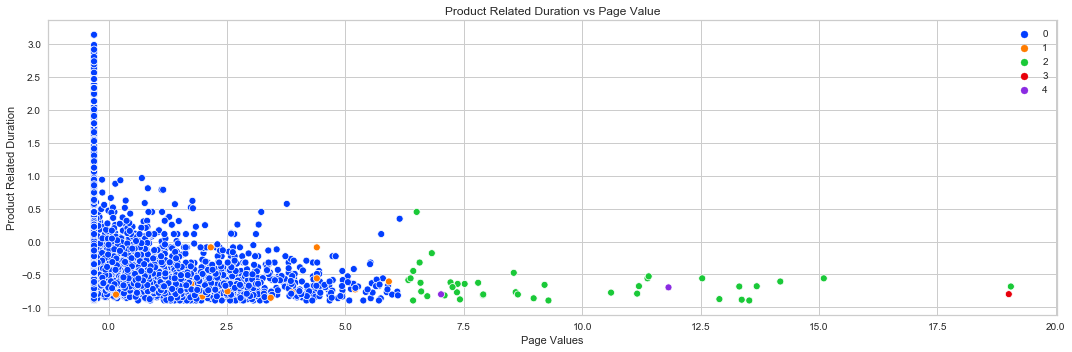

In [64]:
plt.figure(figsize=(15, 5))

pal = sns.color_palette('bright', clusters)
sns.scatterplot(x=X[:,8], y=X[:,7], hue=labels, palette=pal)
plt.ylabel('Product Related Duration')
plt.xlabel('Page Values')
plt.title('Product Related Duration vs Page Value')

plt.tight_layout()
plt.show()

## Agglomerative Clustering
Agglomerative clustering is a form of hierarchical clustering. It uses a bottome up approach; start with many small clusters and merge them together to create bigger clusters. This assumes no particular number of clusters unlike k-means but once two clusters are merged it can't be undone. A dendrogram is a visual history of grouping. It will be used to find the optimal number of clusters using the following criteria:
    1. The largest vertical distance that doesn’t intersect any of the other clusters
    2. A horizontal line at both extremities of the largest distance
    3. The optimal number of clusters is equal to the number of vertical lines going through the horizontal line
In our dendrogram the ideal number of clusters is 3. Each datapoint is linked via ward linkage. Ward linkage is the sum of squared differences within all clusters. The last parameter of our clustering model is the affinity or distance metric. Euclidean method choses the shortest distance between two points.

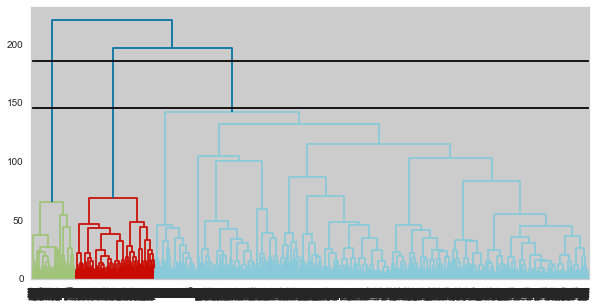

In [70]:
# Chart dendrogram and select ideal number of clusters
plt.figure(figsize=(10, 5))
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))
plt.axhline(y=145, color='black')
plt.axhline(y=195, color='black')
plt.show()

In [71]:
# Fit agglomerative clustering model
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
model.fit(X)
labels = model.labels_

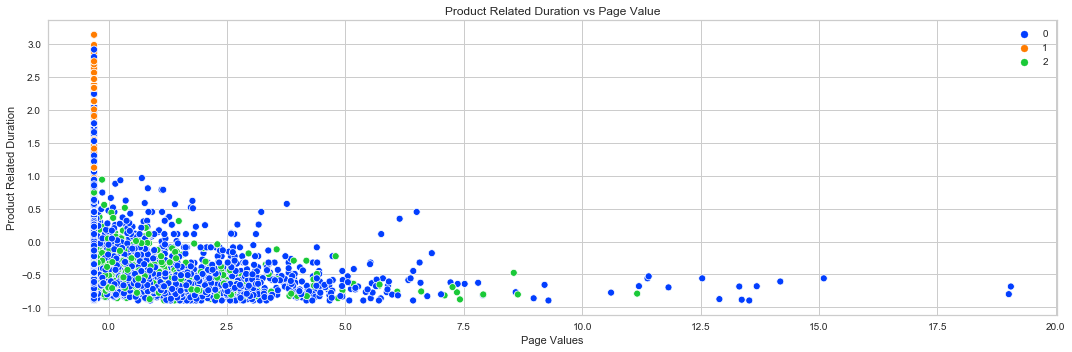

In [73]:
plt.figure(figsize=(15, 5))

pal = sns.color_palette('bright', 3)
sns.scatterplot(x=X[:,8], y=X[:,7], hue=labels, palette=pal)
plt.ylabel('Product Related Duration')
plt.xlabel('Page Values')
plt.title('Product Related Duration vs Page Value')

plt.tight_layout()
plt.show()

### Agglomerative Clustering Results
Unfortunately, similar to the last two clusters the agglomerative clusters did not produce any informative groups. There is too much noise in the data, and a PCA will be utilized to reduce the noise. 

# PCA
Principal Component Analysis (PCA) is a great tool to reduce the dimensions of features. One can explain a large portion of the variance witin dataset by reducing the dimensions. The first step is to make sure that all the features within the PCA are somewhat correlated to the target variable. In this case all variables that are correlated by minimum of .1 or -.1 will be included in the PCA. Furthermore, as identified above bounce rates will be droped as it is highly correlated to the exit rate. The goal here is to reduce bias and noise. 

The next step is to calculate the eigen values and eigen vectors. Eigen values represent magnitude and importance. Only eigen values with a value above 1 will be selected as a PCA component. Eigen vectors represent the directions that the data is dispersed. In the case of the website dataset the ideal number of PCA components is 3. These 3 components represent 67.9% of the data.

In [39]:
# Create a list of column names with correlations 
# above and below .1 for PCA
pca_col = []
tmp = np.abs(df_corr['Revenue'])
tmp = tmp>.1
tmp = pd.DataFrame(tmp)
tmp.reset_index(inplace=True)

for i, x in enumerate(tmp['Revenue']):
    if x == 1:
        pca_col.append(tmp.loc[i, 'index'])

# Remove Revenue
pca_col.remove('Revenue')
pca_col.remove('BounceRates')
print(pca_col)
        

['Administrative', 'Administrative_Duration', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'ExitRates', 'PageValues', 'VisitorType']


In [40]:
features = df[pca_col]
X = StandardScaler().fit_transform(features)

# Transpose X
Xt = X.T
Cx = np.cov(Xt)

# Calculate the eigenvalues and eigenvectors
eig_val, eig_vec = np.linalg.eig(Cx)

# Return number of components above 1
components = 0
for x in eig_val:
    if x > 1:
        components += 1

print('Number of Components: {}'.format(components))

# All components above 1 selected for PCA
pca = PCA(n_components=components)
X_pca = pca.fit_transform(X)

# Print the percentage for each component
print(
    'The percentage of total variance in the dataset explained by the total',
    'components from Sklearn PCA.\n',
    pca.explained_variance_ratio_.sum())

pca_df = pd.DataFrame(data=X_pca)

Number of Components: 3
The percentage of total variance in the dataset explained by the total components from Sklearn PCA.
 0.679854675137134


,0,1,2
0,-3.863161,0.043038,-2.039426
1,-2.053920,-0.293993,-0.243875
2,-1.997037,-0.415350,-1.039964
3,-3.045043,-0.032792,-1.219967
4,-1.008788,-0.573400,0.714443


In [41]:
final_df = pd.concat([pca_df, df['Revenue']], axis=1)
final_df.head()

,0,1,2,Revenue
0,-3.863161,0.043038,-2.039426,0
1,-2.053920,-0.293993,-0.243875,0
2,-1.997037,-0.415350,-1.039964,0
3,-3.045043,-0.032792,-1.219967,0
4,-1.008788,-0.573400,0.714443,0


The PCA components were added to the target variable 'Revenue' to create the modeling dataset. 

## PCA K-Means Cluster
The ideal number of clusters identified by the elbow plot was 5. The first two PCA components were plotted as they represented the largest amount of the variance.

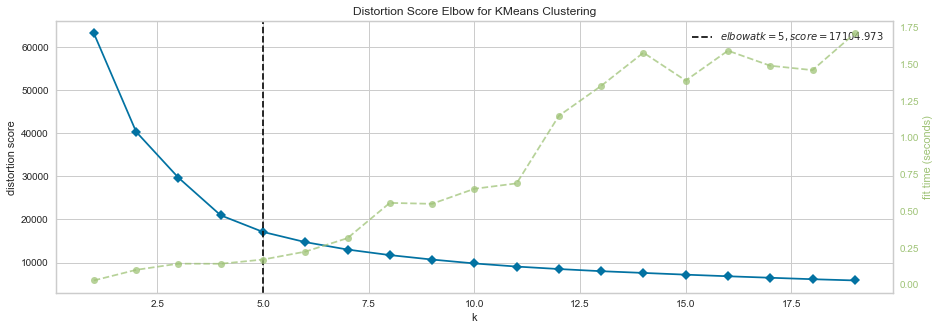

In [42]:
km = KMeans()

plt.figure(figsize=(15, 5))

# Find the optimal number of clusters for KMeans
vis = KElbowVisualizer(km, k=(1,20))
vis.fit(X_pca)
vis.poof()
n = vis.elbow_value_

plt.show()

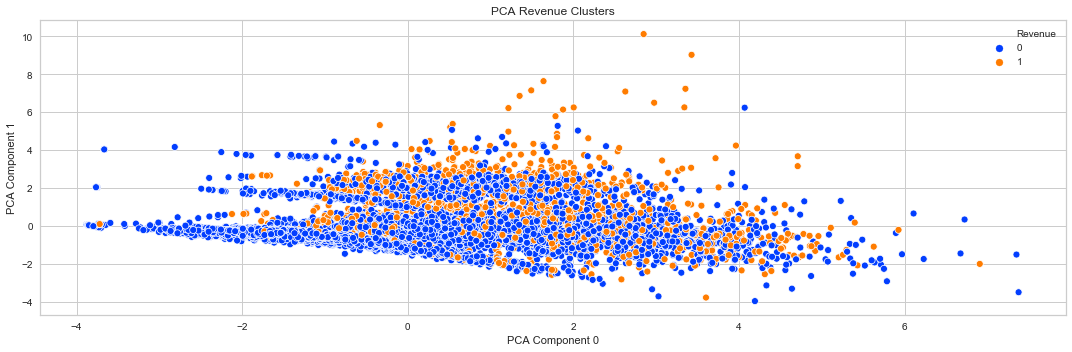

In [75]:
# Plot the revenue clusters
plt.figure(figsize=(15, 5))
pal = sns.color_palette('bright', 2)
sns.scatterplot(x=final_df[0], y=final_df[1], hue=final_df['Revenue'], palette=pal)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('PCA Revenue Scatterplot')

plt.tight_layout()
plt.show()

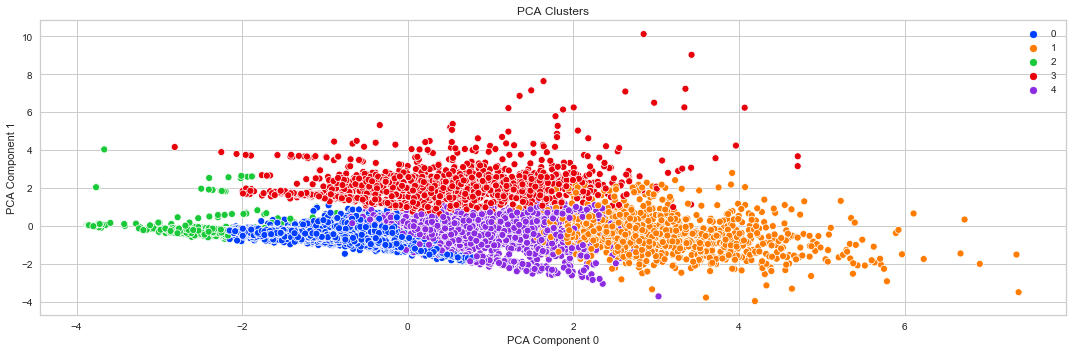

In [43]:
plt.figure(figsize=(15, 5))

km = KMeans(n_clusters=n).fit_predict(X_pca)
pal = sns.color_palette('bright', n)
sns.scatterplot(x=final_df[0], y=final_df[1], hue=km, palette=pal)
plt.xlabel('PCA Component 0')
plt.ylabel('PCA Component 1')
plt.title('PCA Clusters')

plt.tight_layout()
plt.show()

### K - Means Analysis
The pca k-means chart is a massive improvement from the the non-pca charts. There are 5 distinctive group identified above. These five distintive groups could be identified as users of the website. Judging by the PCA revenue scatterplot and the PCA clusters below, cluster number 3 could represent the sales group as it has the largest number sales. Lets assess the proportion of each feature to its pca component below.

## PCA Component Heatmap
Components 0 and 1 have the largest variance of the dataset. The main features of PCA 0 are admin, admin duration, product related duration and exit rates. For PCA 1 the main features are page values and visitor type. 

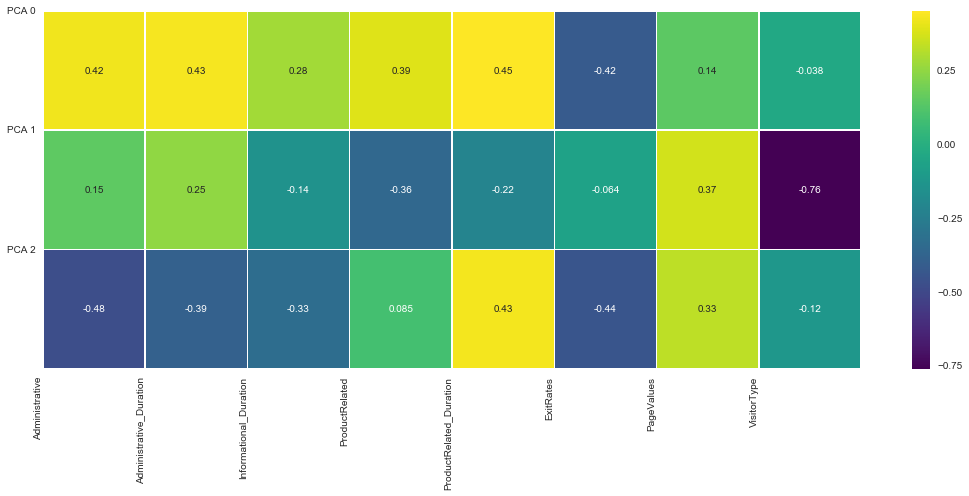

In [45]:
plt.figure(figsize=(15, 7))
sns.heatmap(pca.components_,cmap='viridis', annot=True, linewidths=.5)

plt.yticks(np.arange(3),['PCA 0','PCA 1', 'PCA 2'],
           fontsize=10, rotation='horizontal', va='center')

plt.xticks(range(len(features.columns)),features.columns, rotation='vertical',ha='right')

plt.tight_layout()
plt.show()

## Unsupervised Learning
The business case of this project is to see if one can reliably predict sales based on website metrics. In the sections above, the best features were transposed to create several PCA components. These components will be utilized below to create a model to predict if a user will produce revenue. Keras will be utilized to build a neural network to predict revenue. Keras is a high level API built on TensorFlow. It is more user-friendly and easy to use in comparison to Tensorflow. 

### Model 1: Baseline
Model 1 will be a baseline of the accuracy of the neural network for all future models. For model 1 a classical feed-forward neural network will be built. In a feed-forward neural network, information flows from the input layers, through the hidden layers, and ultimately an output. There are no connects in this neural network that fed back into itself. With this in mind, several key parameters were chosen.

#### Activation Function
The activation function is responsible for transforming the weighted input into the node. Rectified linear unit(relu) was chosen as the activation function. Relu is a nonlinear function that allows complex relationships to be learned. It provides sensitivity to the activation sum and avoids saturation by outpuing the input directly if positive otherwise it will ouput zero. This means that the neural network will have computational simplicity, representation sparsity(capable of outputting zero), linear behavior, and train deep networks.

#### Optimizer

In [54]:
# X is the pca features
X = final_df.drop(final_df['Revenue'], axis=1)

# y is the target variable
y = final_df['Revenue']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [55]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal', input_dim=2))

#Second  Hidden Layer
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal'))

#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
classifier.compile(optimizer='adam',loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
9291/9291 [==============================] - 1s 101us/step - loss: 0.4942 - accuracy: 0.9537
Epoch 2/100
9291/9291 [==============================] - 1s 93us/step - loss: 0.2292 - accuracy: 1.0000
Epoch 3/100
9291/9291 [==============================] - 1s 92us/step - loss: 0.1291 - accuracy: 1.0000
Epoch 4/100
9291/9291 [==============================] - 1s 99us/step - loss: 0.0782 - accuracy: 1.0000
Epoch 5/100
9291/9291 [==============================] - 1s 91us/step - loss: 0.0494 - accuracy: 1.0000
Epoch 6/100
9291/9291 [==============================] - 1s 91us/step - loss: 0.0321 - accuracy: 1.0000
Epoch 7/100
9291/9291 [==============================] - 1s 92us/step - loss: 0.0212 - accuracy: 1.0000
Epoch 8/100
9291/9291 [==============================] - 1s 92us/step - loss: 0.0141 - accuracy: 1.0000
Epoch 9/100
9291/9291 [==============================] - 1s 91us/step - loss: 0.0095 - accuracy: 1.0000
Epoch 10/100
9291/9291 [==============================] - 1s 89

9291/9291 [==============================] - 1s 84us/step - loss: 7.9446e-09 - accuracy: 1.0000
Epoch 77/100
9291/9291 [==============================] - 1s 84us/step - loss: 7.9918e-09 - accuracy: 1.0000
Epoch 78/100
9291/9291 [==============================] - 1s 90us/step - loss: 8.0376e-09 - accuracy: 1.0000
Epoch 79/100
9291/9291 [==============================] - 1s 89us/step - loss: 8.0904e-09 - accuracy: 1.0000
Epoch 80/100
9291/9291 [==============================] - 1s 91us/step - loss: 8.1463e-09 - accuracy: 1.0000
Epoch 81/100
9291/9291 [==============================] - 1s 88us/step - loss: 7.9544e-09 - accuracy: 1.0000
Epoch 82/100
9291/9291 [==============================] - 1s 88us/step - loss: 7.8603e-09 - accuracy: 1.0000
Epoch 83/100
9291/9291 [==============================] - 1s 95us/step - loss: 7.6685e-09 - accuracy: 1.0000
Epoch 84/100
9291/9291 [==============================] - 1s 91us/step - loss: 7.7402e-09 - accuracy: 1.0000
Epoch 85/100
9291/9291 [========

In [56]:
# Evaluate training model
eval_model = classifier.evaluate(X_train, y_train)
eval_model

9291/9291 [==============================] - 0s 16us/step


[6.227917519693994e-09, 1.0]

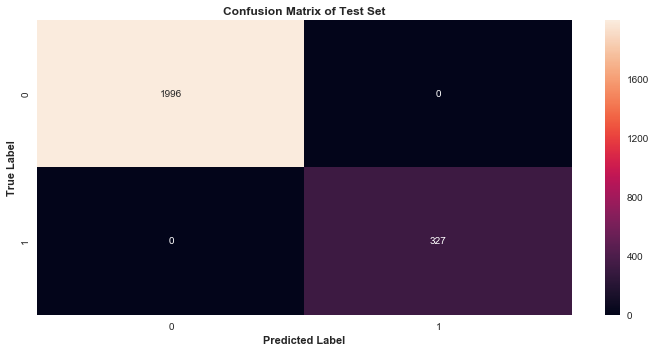

In [57]:
# Predict the test set
y_pred = classifier.predict(X_test)

#If the prediction is greater than 0.5 then the output 1, else 0
y_pred = (y_pred>0.5)

# create heatmap of confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

## Model 2: Undersample

In [46]:
# X is the pca features
X = final_df.drop(final_df['Revenue'], axis=1)

# y is the target variable
y = final_df['Revenue']

sm = RandomUnderSampler(random_state=1)
X, y = sm.fit_sample(X, y)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [47]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal', input_dim=2))

#Second  Hidden Layer
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal'))

#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
2734/2734 [==============================] - 0s 126us/step - loss: 0.6707 - accuracy: 0.5187
Epoch 2/100
2734/2734 [==============================] - 0s 95us/step - loss: 0.4697 - accuracy: 0.8464
Epoch 3/100
2734/2734 [==============================] - 0s 95us/step - loss: 0.2901 - accuracy: 1.0000
Epoch 4/100
2734/2734 [==============================] - 0s 94us/step - loss: 0.2195 - accuracy: 1.0000
Epoch 5/100
2734/2734 [==============================] - 0s 96us/step - loss: 0.1765 - accuracy: 1.0000
Epoch 6/100
2734/2734 [==============================] - 0s 92us/step - loss: 0.1454 - accuracy: 1.0000
Epoch 7/100
2734/2734 [==============================] - 0s 92us/step - loss: 0.1215 - accuracy: 1.0000
Epoch 8/100
2734/2734 [==============================] - 0s 92us/step - loss: 0.1026 - accuracy: 1.0000
Epoch 9/100
2734/2734 [==============================] - 0s 98us/step - loss: 0.0874 - accuracy: 1.0000
Epoch 10/100
2734/2734 [==============================] - 0s 97

2734/2734 [==============================] - 0s 102us/step - loss: 3.0558e-05 - accuracy: 1.0000
Epoch 78/100
2734/2734 [==============================] - 0s 97us/step - loss: 2.7332e-05 - accuracy: 1.0000
Epoch 79/100
2734/2734 [==============================] - 0s 101us/step - loss: 2.4445e-05 - accuracy: 1.0000
Epoch 80/100
2734/2734 [==============================] - 0s 97us/step - loss: 2.1861e-05 - accuracy: 1.0000
Epoch 81/100
2734/2734 [==============================] - 0s 98us/step - loss: 1.9551e-05 - accuracy: 1.0000
Epoch 82/100
2734/2734 [==============================] - 0s 99us/step - loss: 1.7486e-05 - accuracy: 1.0000
Epoch 83/100
2734/2734 [==============================] - 0s 97us/step - loss: 1.5642e-05 - accuracy: 1.0000
Epoch 84/100
2734/2734 [==============================] - 0s 92us/step - loss: 1.3990e-05 - accuracy: 1.0000
Epoch 85/100
2734/2734 [==============================] - 0s 101us/step - loss: 1.2513e-05 - accuracy: 1.0000
Epoch 86/100
2734/2734 [=====

In [48]:
# Evaluate training model
eval_model = classifier.evaluate(X_train, y_train)
eval_model

2734/2734 [==============================] - 0s 22us/step


[2.235013280349498e-06, 1.0]

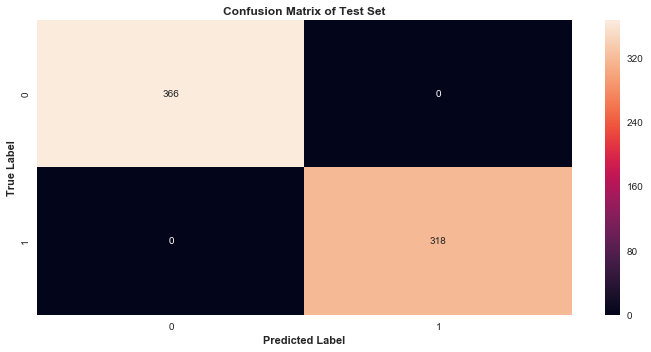

In [49]:
# Predict the test set
y_pred = classifier.predict(X_test)

#If the prediction is greater than 0.5 then the output 1, else 0
y_pred = (y_pred>0.5)

# create heatmap of confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

## Model : Oversample

In [50]:
# X is the pca features
X = final_df.drop(final_df['Revenue'], axis=1)

# y is the target variable
y = final_df['Revenue']

sm = SMOTE(random_state=1)
X, y = sm.fit_sample(X, y)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [51]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal', input_dim=2))

#Second  Hidden Layer
classifier.add(Dense(2, activation='relu', kernel_initializer='random_normal'))

#Output Layer
classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))

#Compiling the neural network
classifier.compile(optimizer='adam',loss='binary_crossentropy', metrics =['accuracy'])

#Fitting the data to the training dataset
classifier.fit(X_train, y_train, batch_size=10, epochs=100)

Epoch 1/100
15848/15848 [==============================] - 2s 101us/step - loss: 0.3838 - accuracy: 0.9143
Epoch 2/100
15848/15848 [==============================] - 1s 92us/step - loss: 0.0983 - accuracy: 1.0000
Epoch 3/100
15848/15848 [==============================] - 1s 91us/step - loss: 0.0414 - accuracy: 1.0000
Epoch 4/100
15848/15848 [==============================] - 1s 86us/step - loss: 0.0197 - accuracy: 1.0000
Epoch 5/100
15848/15848 [==============================] - 2s 95us/step - loss: 0.0098 - accuracy: 1.0000
Epoch 6/100
15848/15848 [==============================] - 1s 91us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 7/100
15848/15848 [==============================] - 1s 91us/step - loss: 0.0026 - accuracy: 1.0000
Epoch 8/100
15848/15848 [==============================] - 1s 89us/step - loss: 0.0013 - accuracy: 1.0000
Epoch 9/100
15848/15848 [==============================] - 1s 94us/step - loss: 7.0229e-04 - accuracy: 1.0000
Epoch 10/100
15848/15848 [===============

15848/15848 [==============================] - 1s 90us/step - loss: 1.8295e-08 - accuracy: 1.0000
Epoch 76/100
15848/15848 [==============================] - 1s 90us/step - loss: 1.8290e-08 - accuracy: 1.0000
Epoch 77/100
15848/15848 [==============================] - 1s 92us/step - loss: 1.8283e-08 - accuracy: 1.0000
Epoch 78/100
15848/15848 [==============================] - 1s 90us/step - loss: 1.8280e-08 - accuracy: 1.0000
Epoch 79/100
15848/15848 [==============================] - 1s 94us/step - loss: 1.8293e-08 - accuracy: 1.0000
Epoch 80/100
15848/15848 [==============================] - 1s 94us/step - loss: 1.8270e-08 - accuracy: 1.0000
Epoch 81/100
15848/15848 [==============================] - 1s 93us/step - loss: 1.8264e-08 - accuracy: 1.0000
Epoch 82/100
15848/15848 [==============================] - 1s 90us/step - loss: 1.8259e-08 - accuracy: 1.0000
Epoch 83/100
15848/15848 [==============================] - 1s 94us/step - loss: 1.8255e-08 - accuracy: 1.0000
Epoch 84/100
1

In [52]:
# Evaluate training model
eval_model = classifier.evaluate(X_train, y_train)
eval_model

15848/15848 [==============================] - 0s 15us/step


[1.815641950455435e-08, 1.0]

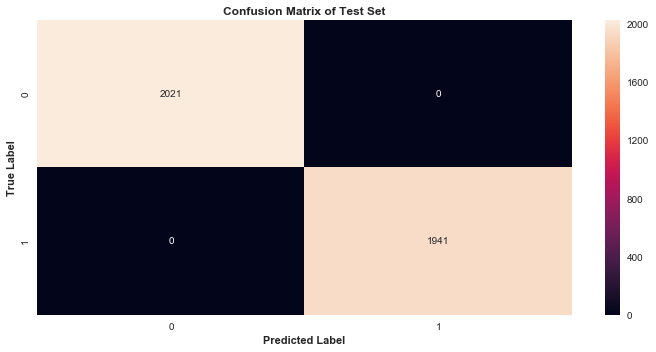

In [53]:
# Predict the test set
y_pred = classifier.predict(X_test)

#If the prediction is greater than 0.5 then the output 1, else 0
y_pred = (y_pred>0.5)

# create heatmap of confusion matrix
plt.figure(figsize=(10, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

plt.ylabel('True Label', fontweight='bold')
plt.xlabel('Predicted Label', fontweight='bold')
plt.title('Confusion Matrix of Test Set', fontweight='bold')

plt.tight_layout()
plt.show()

# Summary and Conclusion

# References
Data - https://www.kaggle.com/roshansharma/online-shoppers-intention
Bounce vs Exit Rate - https://support.google.com/analytics/answer/2525491?hl=en
Page Value - https://support.google.com/analytics/answer/2695658?hl=en